# Setup and Data

In [1]:
# Imports
import pandas as pd
import pyreadstat
import numpy as np
from tabulate import tabulate
import matplotlib.pyplot as plt

# Parameters
start_year = 2019
end_year = 2022
base_year = 2019
top_n = 10
years=range(start_year,end_year+1)
factor = 1 # Factor in case of missing prices. 0 = ignore, 1 = assume no change in price

# Load folder names
folder_names_pathname='Data_clean/CEX_folder_names.csv'
folder_names_df = pd.read_csv(folder_names_pathname)

# CEX data folder
cex_data_folder='/Users/roykisluk/Downloads/Consumer_Expenditure_Survey/'

####################################################

# Functions

# Total consumption, monthly, across all products
def total_consumption_value(df): 
    total_consumption = 0.0
    for j in range(0, len(df)):
        total_consumption += df['omdan'][j]
    return total_consumption

# Function to keep only shared prodcodes
def keep_shared_prodcodes(df1, df2):
    shared_prodcodes = set(df1['prodcode']).intersection(set(df2['prodcode']))
    df1_shared = df1[df1['prodcode'].isin(shared_prodcodes)].reset_index(drop=True)
    df2_shared = df2[df2['prodcode'].isin(shared_prodcodes)].reset_index(drop=True)
    return df1_shared, df2_shared

# Weighting by product
def weighting(df):
    weights = pd.DataFrame(df['prodcode'].unique(), columns=['prodcode'])
    weights['weight'] = 0.0
    total_consumption = total_consumption_value(df)
    for j in range(0, len(weights)):
        weights.loc[j, 'weight'] = df[df['prodcode'] == weights.loc[j, 'prodcode']]['omdan'].sum() / total_consumption
    return weights

# Effective price paid, on average, per product
def average_price(df):
    average_prices = pd.DataFrame(df['prodcode'].unique(), columns=['prodcode'])
    average_prices['price'] = 0.0
    for j in range(0, len(average_prices)):
        average_prices.loc[j, 'price'] = (df[df['prodcode'] == average_prices.loc[j, 'prodcode']]['mehir'] / df[df['prodcode'] == average_prices.loc[j, 'prodcode']]['kamut']).mean()
    return average_prices

# Laspeyres index
def Laspeyres(df_base, df_current):
    # Create index dataframe
    index_df = pd.DataFrame(df_base['prodcode'].unique(), columns=['prodcode'])
    index_df['index'] = 0.0
    # Calculate weights and average prices
    weights = weighting(df_base)
    average_prices_base = average_price(df_base)
    average_prices_current = average_price(df_current)
    # Merge weights and average prices into index dataframe
    index_df = index_df.merge(weights, on='prodcode', how='left')
    index_df = index_df.merge(average_prices_base, on='prodcode', how='left', suffixes=('', '_base'))
    index_df = index_df.merge(average_prices_current, on='prodcode', how='left', suffixes=('_base', '_current'))
    # Calculate index
    total_index = 0.0
    # Missing prices counter
    missing_base_prices = 0
    missing_current_prices = 0
    for j in range(len(index_df)):
        # Check for missing prices
        price_current = index_df.loc[j, 'price_current']
        price_base = index_df.loc[j, 'price_base']
        if price_base == 0 or pd.isna(price_base) or np.isinf(price_base):
            index_df.loc[j, 'index'] = factor * 100
            missing_base_prices += 1
            print(f"prodcode {index_df.loc[j, 'prodcode']}: invalid price_base")
            continue
        if price_current == 0 or pd.isna(price_current) or np.isinf(price_current):
            index_df.loc[j, 'index'] = factor * 100
            missing_current_prices += 1
            print(f"prodcode {index_df.loc[j, 'prodcode']}: invalid price_current")
            continue
        # Calculate index for each product
        index_df.loc[j, 'index'] = (price_current / price_base) * 100
    # Calculate yearly price index
    for j in range(len(index_df)):
        weight = index_df.loc[j, 'weight']
        total_index += weight * index_df.loc[j, 'index']
    print(f"Missing base prices: {missing_base_prices}")
    print(f"Missing current prices: {missing_current_prices}")
    return index_df, total_index

def merge_to_secondary(df):
    df['prodcode_secondary'] = df['prodcode'].astype(str).str[:3]
    grouped = df.groupby('prodcode_secondary', group_keys=False).apply(
        lambda x: pd.Series({
            'price_index': np.average(x['index'], weights=x['weight']) if x['weight'].sum() > 0 else np.nan,
            'total_weight': x['weight'].sum()
        }),
        include_groups=False 
    ).reset_index()
    grouped.rename(columns={'prodcode_secondary': 'prodcode'}, inplace=True)
    grouped.rename(columns={'total_weight': 'weight'}, inplace=True)
    return grouped

def merge_to_primary(df):
    df['prodcode_primary'] = df['prodcode'].astype(str).str[:2]
    
    grouped = df.groupby('prodcode_primary', group_keys=False).apply(
        lambda x: pd.Series({
            'price_index': np.average(x['price_index'], weights=x['weight']) if x['weight'].sum() > 0 else np.nan,
            'total_weight': x['weight'].sum()
        }),
        include_groups=False
    ).reset_index()
    grouped.rename(columns={'prodcode_primary': 'prodcode'}, inplace=True)
    grouped.rename(columns={'total_weight': 'weight'}, inplace=True)
    return grouped

def display_top_bottom_price_indexes(df):
    for year in years:
        if year == base_year:
            continue
        df_year = df[df['Year'] == year]
        df_top = df_year.nlargest(top_n, 'price_index')
        df_bottom = df_year.nsmallest(top_n, 'price_index')
        print(f"Year: {year}")
        print("Top price indexes:")
        print(tabulate(df_top, headers='keys', tablefmt='psql'))
        print("Bottom price indexes:")
        print(tabulate(df_bottom, headers='keys', tablefmt='psql'))
        # Plot top and bottom price indexes

        fig, axes = plt.subplots(2, 1, figsize=(12, 10))

        # Plot top price indexes
        axes[0].bar(df_top['prodcode'].astype(str), df_top['price_index'])
        axes[0].set_title(f'Top {top_n} Price Indexes for Year {year}')
        axes[0].set_xlabel('Product Code')
        axes[0].set_ylabel('Price Index')

        # Plot bottom price indexes
        axes[1].bar(df_bottom['prodcode'].astype(str), df_bottom['price_index'])
        axes[1].set_title(f'Bottom {top_n} Price Indexes for Year {year}')
        axes[1].set_xlabel('Product Code')
        axes[1].set_ylabel('Price Index')

        plt.tight_layout()
        plt.show()


In [2]:
# Load price data for each year
dfs_prices = {}
for year in years:
    subfolder = folder_names_df.loc[folder_names_df['Year'] == year, 'Folder_Name'].values[0]
    data_prices_pathname = f"{cex_data_folder}{subfolder}/{subfolder}datayoman.sas7bdat"
    df, meta = pyreadstat.read_sas7bdat(data_prices_pathname)
    df.columns = df.columns.str.lower()
    dfs_prices[year] = df

In [3]:
# Calculate weights and price indexes
yearly_price_index = {}
df_price_index = {}
for year in years:
    df_base, df_current = keep_shared_prodcodes(dfs_prices[base_year], dfs_prices[year])
    df_price_index[year], yearly_price_index[year] = Laspeyres(df_base, df_current)

prodcode 312090.0: invalid price_base
prodcode 383166.0: invalid price_base
prodcode 300418.0: invalid price_base
prodcode 343251.0: invalid price_base
prodcode 302133.0: invalid price_base
prodcode 309997.0: invalid price_base
prodcode 302034.0: invalid price_base
prodcode 302018.0: invalid price_base
prodcode 309088.0: invalid price_base
prodcode 303099.0: invalid price_base
prodcode 313189.0: invalid price_base
prodcode 398016.0: invalid price_base
prodcode 302224.0: invalid price_base
prodcode 302174.0: invalid price_base
prodcode 309344.0: invalid price_base
prodcode 312298.0: invalid price_base
prodcode 317198.0: invalid price_base
Missing base prices: 17
Missing current prices: 0
prodcode 312090.0: invalid price_base
prodcode 383166.0: invalid price_base
prodcode 300418.0: invalid price_base
prodcode 309153.0: invalid price_current
prodcode 343251.0: invalid price_base
prodcode 302133.0: invalid price_base
prodcode 309997.0: invalid price_base
prodcode 302034.0: invalid price_ba

In [4]:
# Combine all years into a single dataframe
combined_df = pd.concat(df_price_index.values(), keys=df_price_index.keys(), names=['Year', 'Index']).reset_index(level='Index', drop=True).reset_index()
combined_df = combined_df[['Year', 'prodcode', 'index', 'weight']]
print(combined_df)

      Year  prodcode        index    weight
0     2019  304113.0   100.000000  0.004327
1     2019  304170.0   100.000000  0.004127
2     2019  335075.0   100.000000  0.000353
3     2019  317065.0   100.000000  0.000568
4     2019  317131.0   100.000000  0.000335
...    ...       ...          ...       ...
3493  2022  373282.0   145.833333  0.000008
3494  2022  371450.0  1750.000000  0.000000
3495  2022  395137.0   356.953642  0.000010
3496  2022  341016.0    58.100000  0.000164
3497  2022  394122.0   301.507538  0.000001

[3498 rows x 4 columns]


In [5]:
# Merge to secondary and primary categories
df_secondary = {}
df_primary = {}
for year in years:
    df_secondary[year] = merge_to_secondary(df_price_index[year])
    df_primary[year] = merge_to_primary(df_secondary[year])

# Combine secondary and primary categories into a single dataframe
combined_secondary_df = pd.concat(df_secondary.values(), keys=df_secondary.keys(), names=['Year', 'Index']).reset_index(level='Index', drop=True).reset_index()
combined_primary_df = pd.concat(df_primary.values(), keys=df_primary.keys(), names=['Year', 'Index']).reset_index(level='Index', drop=True).reset_index()

# Keep only the necessary columns
combined_secondary_df = combined_secondary_df[['Year', 'prodcode', 'price_index', 'weight']]
combined_primary_df = combined_primary_df[['Year', 'prodcode', 'price_index', 'weight']]

# Output

In [6]:
# Display yearly price index per year in tabulate
print("Yearly Price Index:")
print(tabulate(yearly_price_index.items(), headers=["Year", "Price Index"], tablefmt="grid"))

Yearly Price Index:
+--------+---------------+
|   Year |   Price Index |
+========+===============+
|   2019 |       100     |
+--------+---------------+
|   2020 |       103.999 |
+--------+---------------+
|   2021 |       106.896 |
+--------+---------------+
|   2022 |       110.268 |
+--------+---------------+


## Top Increases and Decreases

Top and Bottom Price Indexes for Combined Secondary DataFrame:
Year: 2020
Top price indexes:
+-----+--------+------------+---------------+-------------+
|     |   Year |   prodcode |   price_index |      weight |
|-----+--------+------------+---------------+-------------|
|  77 |   2020 |        211 |       439.957 | 4.05606e-06 |
| 132 |   2020 |        382 |       196.612 | 0.00747881  |
| 102 |   2020 |        333 |       190.26  | 0.0226039   |
|  78 |   2020 |        212 |       180.763 | 0.0013889   |
| 124 |   2020 |        371 |       165.069 | 0.0263941   |
| 130 |   2020 |        378 |       134.965 | 0.00299369  |
| 122 |   2020 |        363 |       132.633 | 0.0119538   |
| 145 |   2020 |        423 |       131.318 | 0.0130477   |
| 116 |   2020 |        356 |       129.544 | 0.000667656 |
| 131 |   2020 |        381 |       123.649 | 0.00937737  |
+-----+--------+------------+---------------+-------------+
Bottom price indexes:
+-----+--------+------------+---------------+

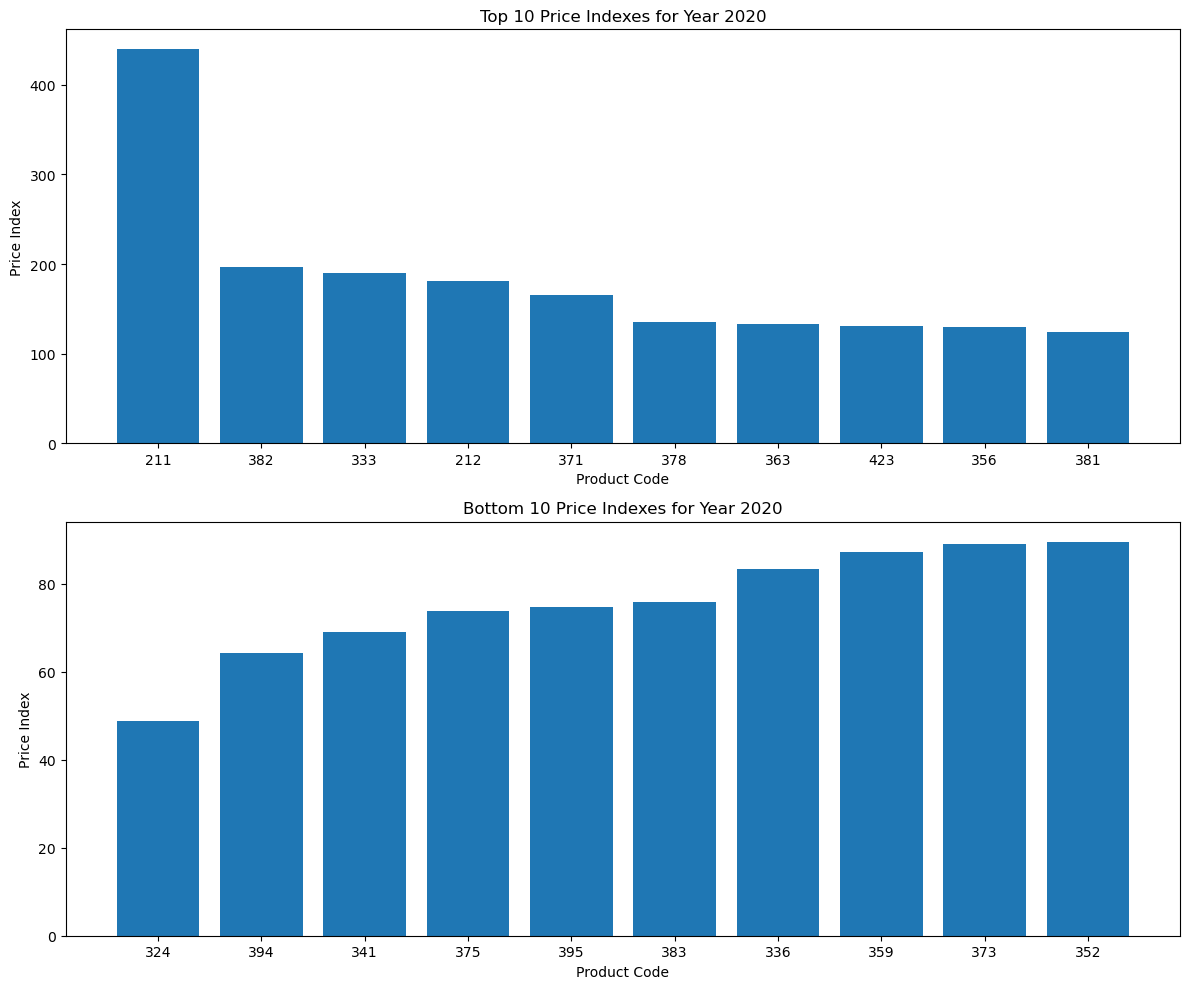

Year: 2021
Top price indexes:
+-----+--------+------------+---------------+-------------+
|     |   Year |   prodcode |   price_index |      weight |
|-----+--------+------------+---------------+-------------|
| 150 |   2021 |        222 |       662.638 | 0.00025602  |
| 147 |   2021 |        211 |       462.791 | 4.17004e-06 |
| 219 |   2021 |        442 |       340.477 | 0.00734914  |
| 193 |   2021 |        362 |       220.84  | 0.00968083  |
| 204 |   2021 |        382 |       214.473 | 0.00817601  |
| 191 |   2021 |        359 |       169.854 | 0.00805123  |
| 175 |   2021 |        334 |       146.267 | 0.00962263  |
| 166 |   2021 |        316 |       136.563 | 0.000450498 |
| 179 |   2021 |        342 |       133.666 | 0.0149382   |
| 186 |   2021 |        354 |       128.29  | 0.00516569  |
+-----+--------+------------+---------------+-------------+
Bottom price indexes:
+-----+--------+------------+---------------+-------------+
|     |   Year |   prodcode |   price_index |   

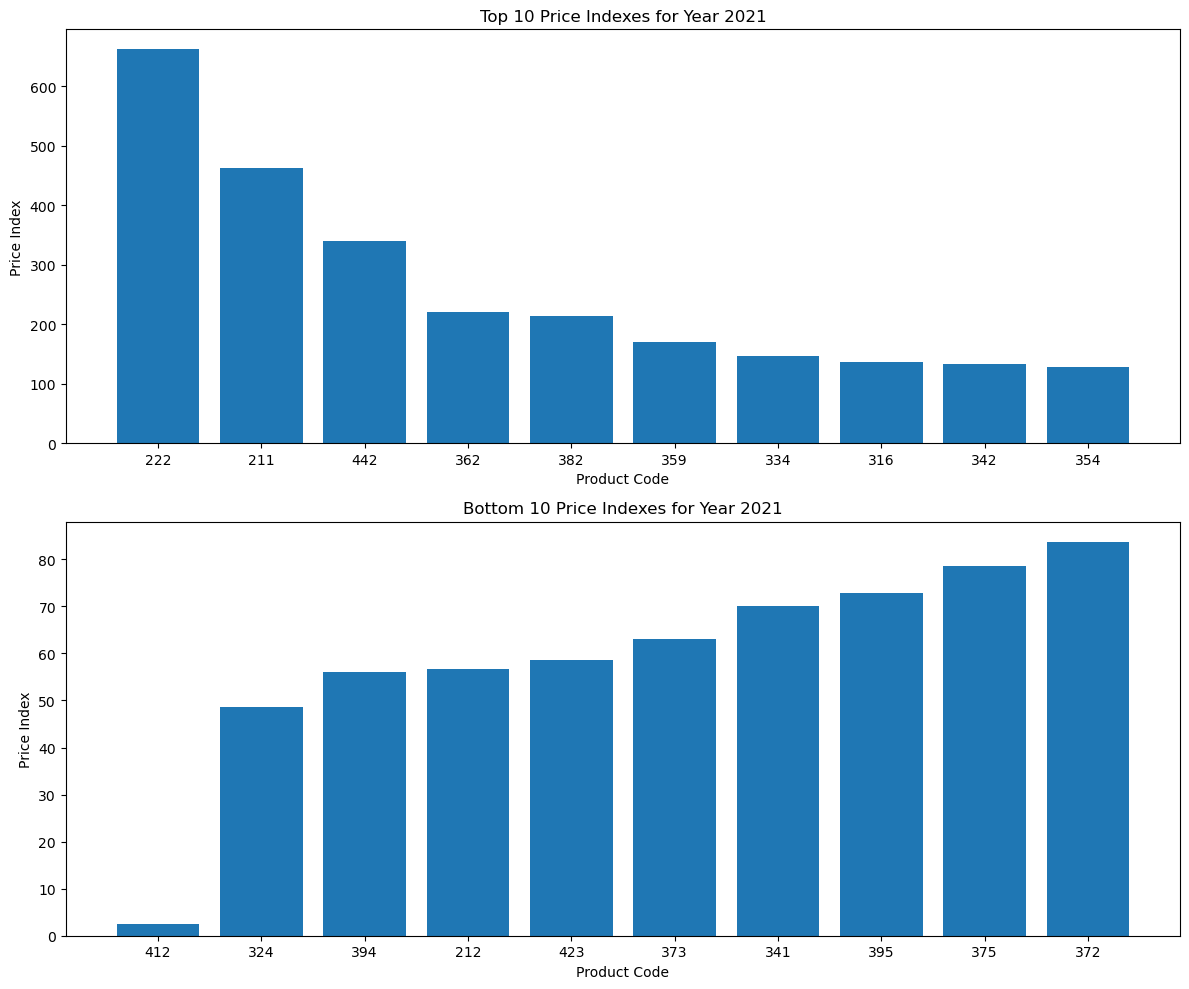

Year: 2022
Top price indexes:
+-----+--------+------------+---------------+-------------+
|     |   Year |   prodcode |   price_index |      weight |
|-----+--------+------------+---------------+-------------|
| 220 |   2022 |        211 |       502.78  | 4.01224e-06 |
| 290 |   2022 |        411 |       472.293 | 0.0039288   |
| 291 |   2022 |        412 |       209.687 | 0.000378544 |
| 292 |   2022 |        423 |       191.84  | 0.0126114   |
| 224 |   2022 |        222 |       180.237 | 0.000246332 |
| 243 |   2022 |        321 |       177.733 | 1.43485e-05 |
| 293 |   2022 |        442 |       164.254 | 0.00707105  |
| 253 |   2022 |        342 |       139.489 | 0.0147255   |
| 231 |   2022 |        306 |       136.716 | 0.00879685  |
| 248 |   2022 |        333 |       133.464 | 0.0224285   |
+-----+--------+------------+---------------+-------------+
Bottom price indexes:
+-----+--------+------------+---------------+------------+
|     |   Year |   prodcode |   price_index |    

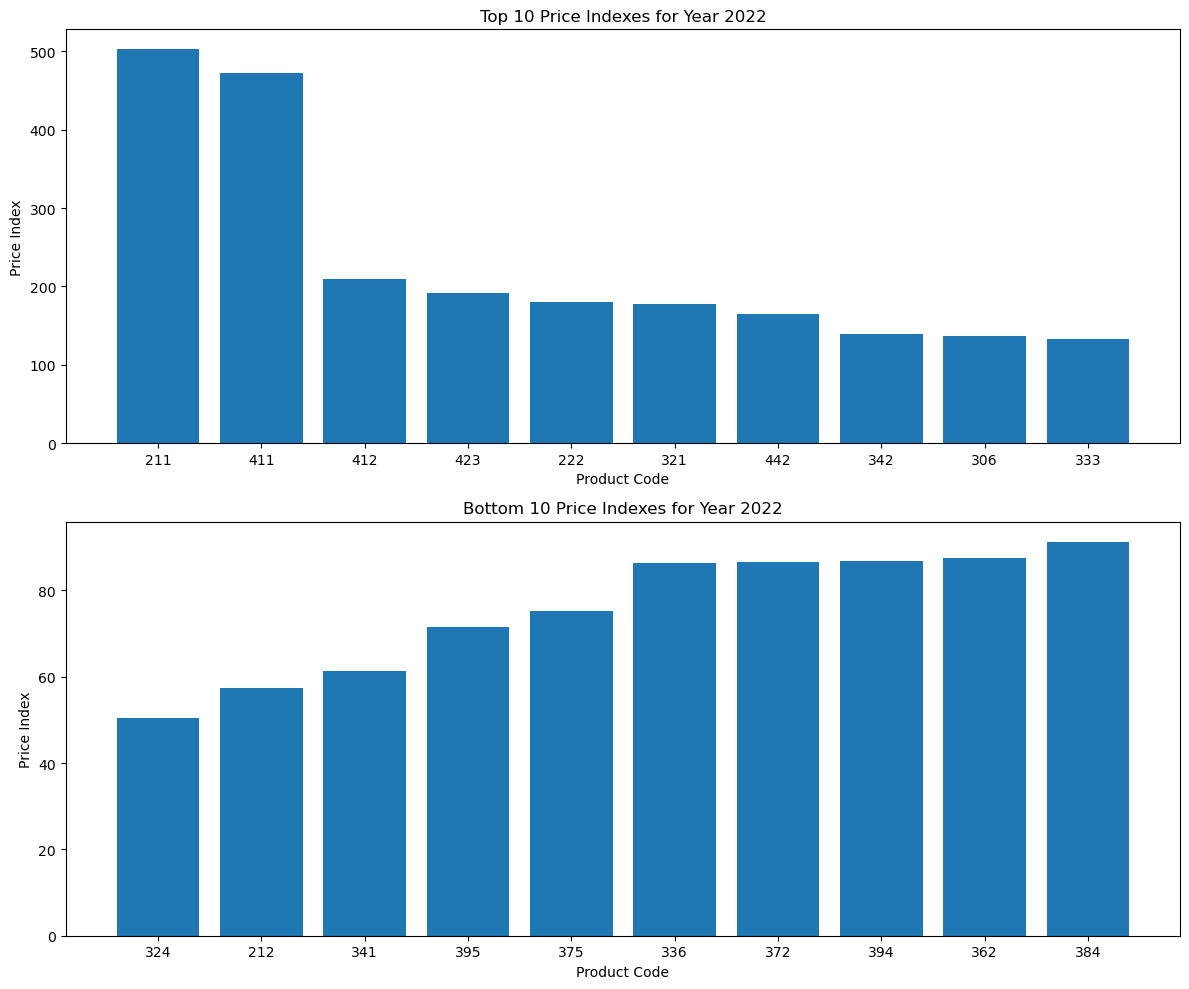

Top and Bottom Price Indexes for Combined Primary DataFrame:
Year: 2020
Top price indexes:
+----+--------+------------+---------------+------------+
|    |   Year |   prodcode |   price_index |     weight |
|----+--------+------------+---------------+------------|
| 16 |   2020 |         21 |       181.518 | 0.00139295 |
| 29 |   2020 |         42 |       131.318 | 0.0130477  |
| 25 |   2020 |         37 |       122.11  | 0.0851222  |
| 21 |   2020 |         33 |       121.153 | 0.0895328  |
| 24 |   2020 |         36 |       118.102 | 0.0549807  |
| 17 |   2020 |         22 |       109.731 | 0.0310883  |
| 28 |   2020 |         41 |       106.154 | 0.00393508 |
| 18 |   2020 |         30 |       103.457 | 0.28218    |
| 30 |   2020 |         44 |       103.103 | 0.00711495 |
| 19 |   2020 |         31 |       102.604 | 0.0693694  |
+----+--------+------------+---------------+------------+
Bottom price indexes:
+----+--------+------------+---------------+------------+
|    |   Year |  

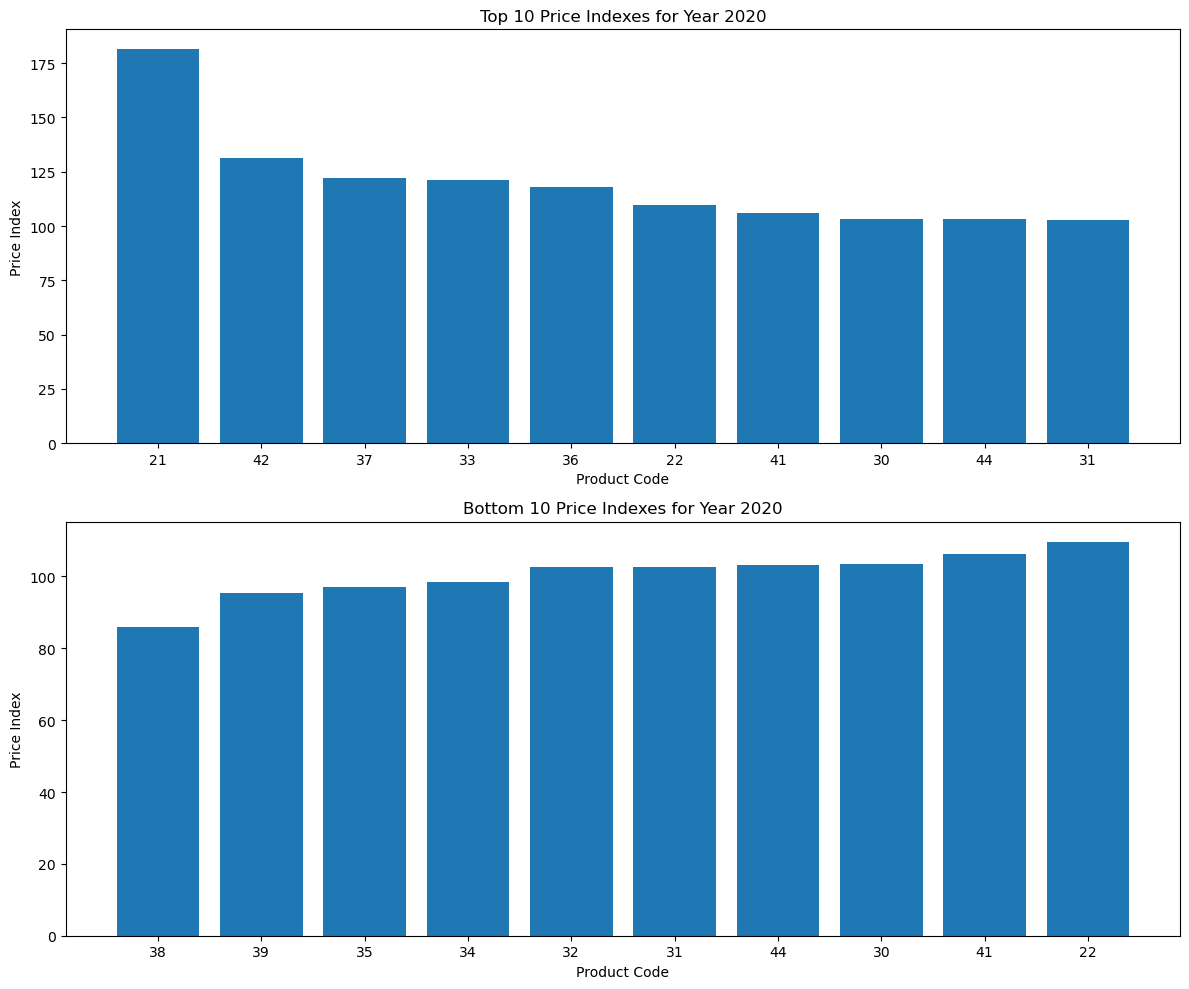

Year: 2021
Top price indexes:
+----+--------+------------+---------------+------------+
|    |   Year |   prodcode |   price_index |     weight |
|----+--------+------------+---------------+------------|
| 45 |   2021 |         44 |       340.477 | 0.00734914 |
| 39 |   2021 |         36 |       129.463 | 0.0565127  |
| 41 |   2021 |         38 |       110.972 | 0.127003   |
| 36 |   2021 |         33 |       109.587 | 0.0918535  |
| 43 |   2021 |         41 |       108.945 | 0.0044391  |
| 38 |   2021 |         35 |       108.717 | 0.061713   |
| 32 |   2021 |         22 |       107.946 | 0.032218   |
| 33 |   2021 |         30 |       104.952 | 0.290127   |
| 37 |   2021 |         34 |       103.958 | 0.0514776  |
| 34 |   2021 |         31 |       103.17  | 0.0713188  |
+----+--------+------------+---------------+------------+
Bottom price indexes:
+----+--------+------------+---------------+-----------+
|    |   Year |   prodcode |   price_index |    weight |
|----+--------+-------

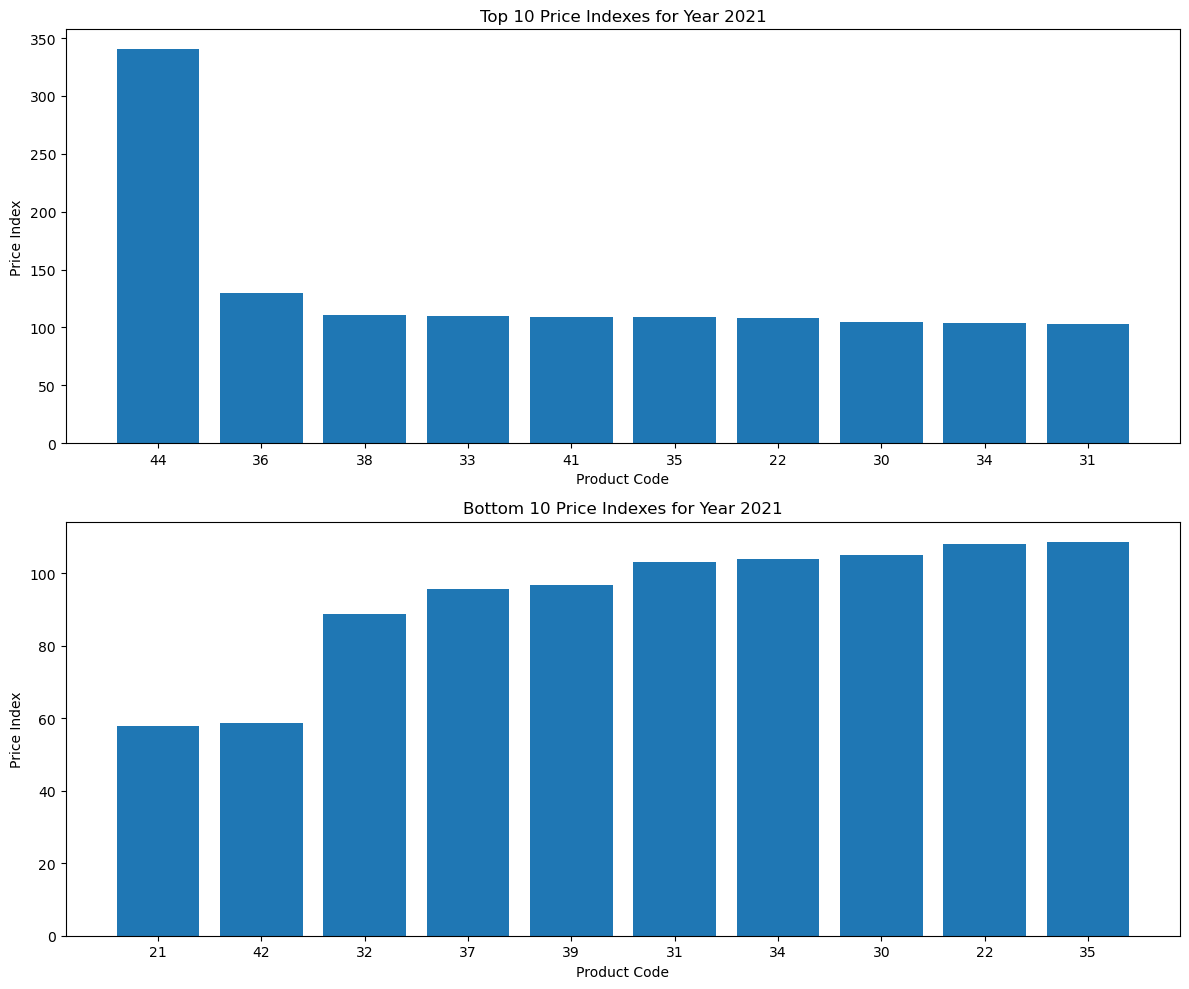

Year: 2022
Top price indexes:
+----+--------+------------+---------------+------------+
|    |   Year |   prodcode |   price_index |     weight |
|----+--------+------------+---------------+------------|
| 58 |   2022 |         41 |       449.214 | 0.00430734 |
| 59 |   2022 |         42 |       191.84  | 0.0126114  |
| 60 |   2022 |         44 |       163.08  | 0.00722463 |
| 47 |   2022 |         22 |       114.678 | 0.0309989  |
| 51 |   2022 |         33 |       114.591 | 0.0886606  |
| 48 |   2022 |         30 |       112.214 | 0.279126   |
| 54 |   2022 |         36 |       110.59  | 0.0532908  |
| 55 |   2022 |         37 |       106.988 | 0.0912449  |
| 52 |   2022 |         34 |       104.846 | 0.0498038  |
| 49 |   2022 |         31 |       104.407 | 0.0686201  |
+----+--------+------------+---------------+------------+
Bottom price indexes:
+----+--------+------------+---------------+-----------+
|    |   Year |   prodcode |   price_index |    weight |
|----+--------+-------

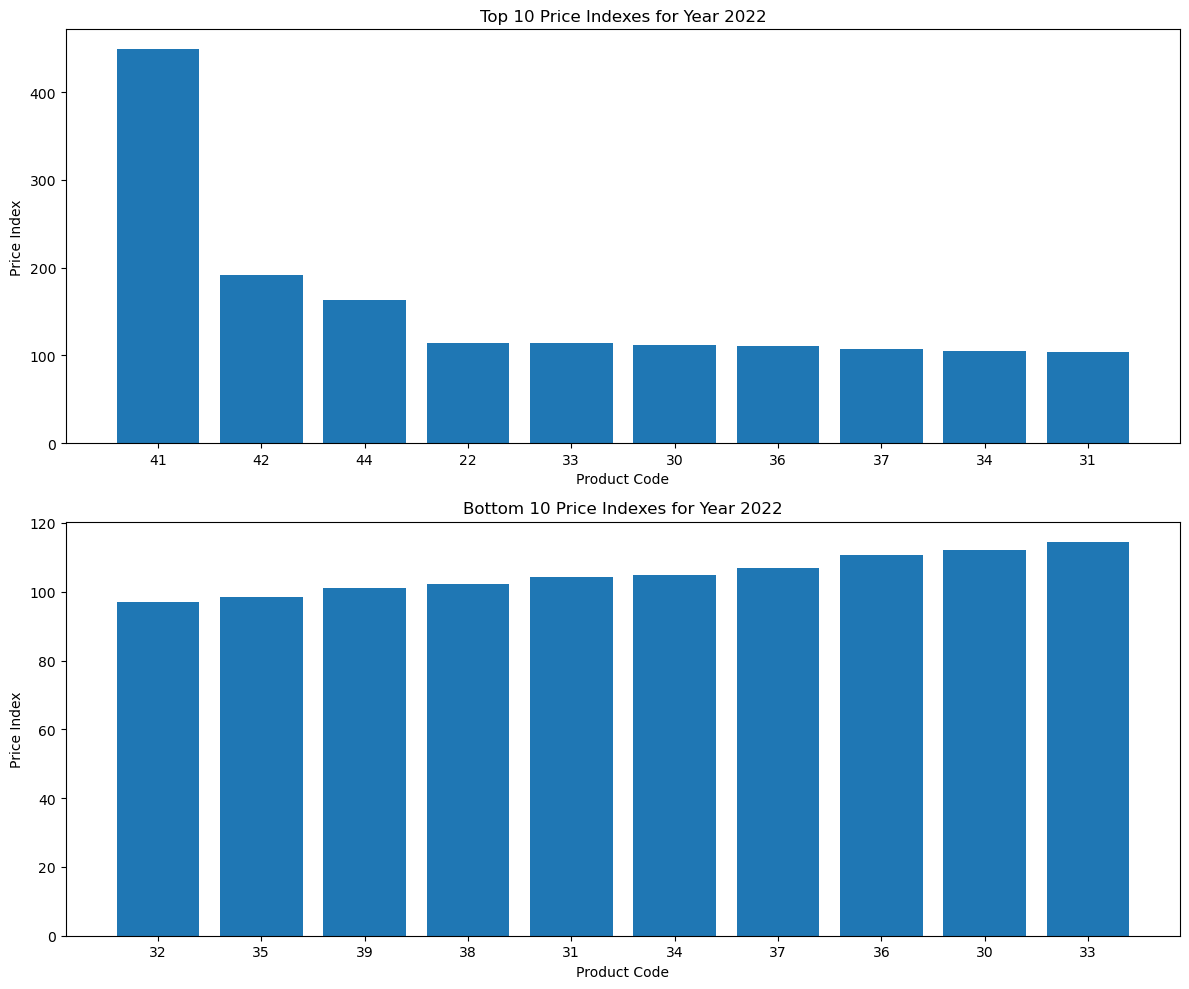

In [7]:
# Display top and bottom price indexes for combined secondary dataframe
print("Top and Bottom Price Indexes for Combined Secondary DataFrame:")
display_top_bottom_price_indexes(combined_secondary_df)

# Display top and bottom price indexes for combined primary dataframe
print("Top and Bottom Price Indexes for Combined Primary DataFrame:")
display_top_bottom_price_indexes(combined_primary_df)

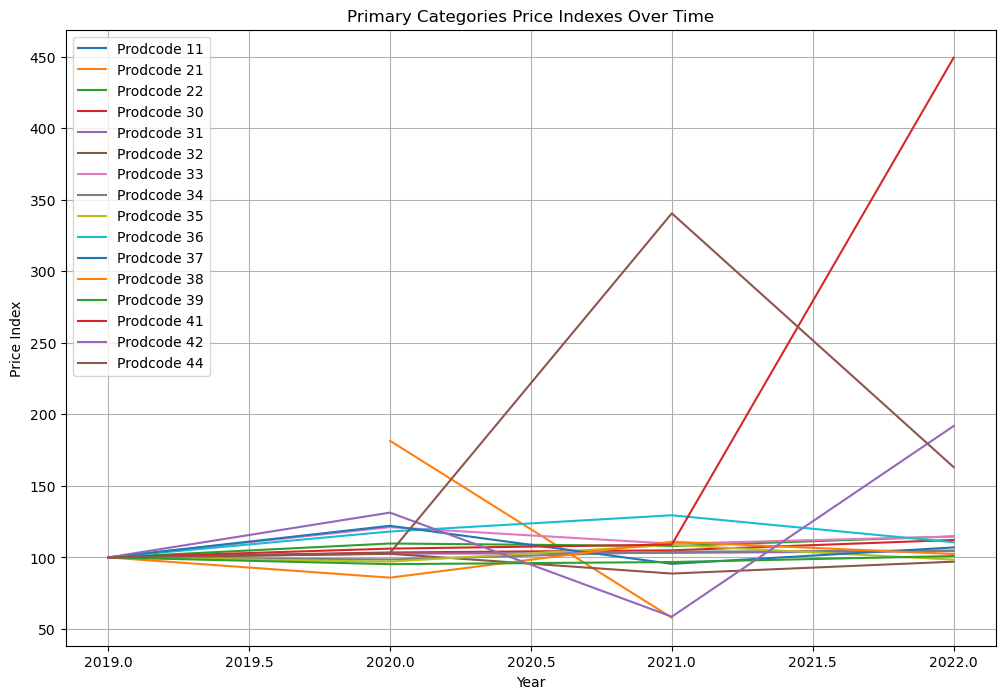

In [8]:
# Plot primary categories price indexes over time
plt.figure(figsize=(12, 8))

for prodcode in combined_primary_df['prodcode'].unique():
    df_prodcode = combined_primary_df[combined_primary_df['prodcode'] == prodcode]
    plt.plot(df_prodcode['Year'], df_prodcode['price_index'], label=f'Prodcode {prodcode}')

plt.xlabel('Year')
plt.ylabel('Price Index')
plt.title('Primary Categories Price Indexes Over Time')
plt.legend()
plt.grid(True)
plt.show()